In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBRegressor, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
def etl_pipeline(df, is_train = False, create_interactions = False, fillna_dict = None,\
                 single_interaction_vars = None, higher_interaction_vars = None, df_grouping_train = None):
    df_etl = df.loc[:,:]
    if is_train == True:
        global_filter = (df_etl['return'] < 0.1) & (df_etl['pf_category'] != 'E') & (df_etl['type'] != 'G') & (df_etl['bought'] < 1e10)
        df_etl = df_etl.loc[global_filter, :]
    
    # encode basic variables
    df_etl['indicator_code'] = df_etl['indicator_code'].isnull().apply(lambda x: int(x))
    hedge_value_dict = {True:1, False:0}
    df_etl['hedge_value'] = df_etl['hedge_value'].apply(lambda x: hedge_value_dict[x] if x in hedge_value_dict else 2)
    df_etl['has_desk_id'] = df_etl['desk_id'].isnull().apply(lambda x: int(x))
    
    # create new variables
    df_etl['has_hedge_value'] = df_etl['hedge_value'].apply(lambda x: 0 if x != 2 else 2)
    df_etl['status'] = df_etl['status'].apply(lambda x: 1 if x == True else 0)
    df_etl['sell_year'] = df_etl['sell_date'].apply(lambda x: x//10000)
    df_etl['sell_month'] = df_etl['sell_date'].apply(lambda x: (x//100)%100)
    for col1, col2 in zip(['start_date', 'start_date', 'creation_date'], ['creation_date', 'sell_date', 'sell_date']):
        df_etl[col1 + '_' + col2] = df_etl.apply(lambda row: (datetime.strptime(str(row[col1]), '%Y%m%d') - \
                                                      datetime.strptime(str(row[col2]), '%Y%m%d')).days, axis = 1)
    df_etl['sold_bought'] = df_etl['sold'] - df_etl['bought']
    df_etl['libor_rate_missing'] = df_etl['libor_rate'].isnull().apply(lambda x: int(x))

    # fill missing values
    if fillna_dict is not None:
        df_etl.fillna(fillna_dict, inplace = True)
        
    df_etl['euribor_plus_libor'] = df_etl['euribor_rate'] + df_etl['libor_rate']
    df_etl['euribor_minus_libor'] = df_etl['euribor_rate'] - df_etl['libor_rate']
    
    if create_interactions == True and is_train == True:
        assert single_interaction_vars is not None and higher_interaction_vars is not None
        df_grouping = {}
        for var_to_group in single_interaction_vars:
            print (var_to_group)
            df_grouping[var_to_group] = df_etl.groupby([var_to_group])\
                                              .agg({'return':[np.mean, np.median, np.max, np.min, 'count']})
            new_col_names =  [df_grouping[var_to_group].index.name] + ['_'.join([df_grouping[var_to_group].index.name] + list(x)) \
                              for x in (df_grouping[var_to_group].columns.ravel())]
            # print (new_col_names)
            df_grouping[var_to_group].reset_index(inplace = True)
            df_grouping[var_to_group].columns = new_col_names
            for col in df_grouping[var_to_group].columns:
                if '_count' in col:
                    df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

            df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = var_to_group, how = 'left')

        for var_to_group in higher_interaction_vars:
            print (var_to_group)
            df_grouping[var_to_group] = df_etl.groupby(list(var_to_group))\
                                          .agg({'return':[np.mean, np.median, np.max, np.min, 'count']})
            new_col_names =  list(var_to_group) + ['_'.join(['_'.join(var_to_group)] + list(x)) \
                              for x in (df_grouping[var_to_group].columns.ravel())]
            df_grouping[var_to_group].reset_index(inplace = True)
            df_grouping[var_to_group].columns = new_col_names
            for col in df_grouping[var_to_group].columns:
                if '_count' in col:
                    df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

            df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = list(var_to_group), how = 'left')
            
    if is_train == False and create_interactions == True:
        assert df_grouping_train is not None
        for var_to_group in df_grouping_train.keys():
            df_etl = pd.merge(left = df_etl, right = df_grouping_train[var_to_group], on = var_to_group, how = 'left')
        
    if is_train == True:
        if (len(df_grouping) > 0):
            return (df_etl, df_grouping)
    return (df_etl)
    

In [4]:
df = pd.read_csv('../inputs/train.csv')
fillna_dict = {'euribor_rate' : df['euribor_rate'].median(),
               'libor_rate' : df['libor_rate'].median(),
               'desk_id' : 'NA'}
single_interaction_vars = ['pf_category', 'country_code', 'type', 'indicator_code', 'hedge_value',\
                           'status', 'sell_year', 'sell_month']
higher_interaction_vars = [('office_id', 'country_code')]

In [5]:
df, df_grouping_train = etl_pipeline(df, is_train = True, create_interactions = True, fillna_dict = fillna_dict,\
                                     single_interaction_vars = single_interaction_vars, \
                                     higher_interaction_vars = higher_interaction_vars)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

pf_category
country_code
type
indicator_code
hedge_value
status
sell_year
sell_month
('office_id', 'country_code')


In [35]:
print (df.dtypes)

portfolio_id                             object
desk_id                                  object
office_id                                object
pf_category                              object
start_date                                int64
sold                                    float64
country_code                             object
euribor_rate                            float64
currency                                 object
libor_rate                              float64
bought                                  float64
creation_date                             int64
indicator_code                            int64
sell_date                                 int64
type                                     object
hedge_value                               int64
status                                    int64
return                                  float64
has_desk_id                               int64
has_hedge_value                           int64
sell_year                               

In [6]:
input_cols_xgb_encode = ['office_id', 'pf_category', 'country_code', 'type'] 
input_cols_xgb_numeric = df.dtypes[(df.dtypes == np.int64) | (df.dtypes == np.float64)].index.tolist()
# print (input_cols_xgb_numeric)
input_cols_xgb_numeric.remove('return')
target_cols_xgb = ['return']

In [7]:
print (input_cols_xgb_numeric)

['start_date', 'sold', 'euribor_rate', 'libor_rate', 'bought', 'creation_date', 'indicator_code', 'sell_date', 'hedge_value', 'status', 'has_desk_id', 'has_hedge_value', 'sell_year', 'sell_month', 'start_date_creation_date', 'start_date_sell_date', 'creation_date_sell_date', 'sold_bought', 'libor_rate_missing', 'euribor_plus_libor', 'euribor_minus_libor', 'pf_category_return_mean', 'pf_category_return_median', 'pf_category_return_amax', 'pf_category_return_amin', 'pf_category_return_count', 'country_code_return_mean', 'country_code_return_median', 'country_code_return_amax', 'country_code_return_amin', 'country_code_return_count', 'type_return_mean', 'type_return_median', 'type_return_amax', 'type_return_amin', 'type_return_count', 'indicator_code_return_mean', 'indicator_code_return_median', 'indicator_code_return_amax', 'indicator_code_return_amin', 'indicator_code_return_count', 'hedge_value_return_mean', 'hedge_value_return_median', 'hedge_value_return_amax', 'hedge_value_return_am

In [8]:
# remove low feature importance columns
low_importance_cols = ['hedge_value_return_count','status_return_amax','status_return_amin','status_return_count','hedge_value_return_amax','indicator_code_return_amin','has_hedge_value','has_desk_id','indicator_code_return_amax','indicator_code_return_median','hedge_value','hedge_value_return_amin','indicator_code_return_count']
low_importance_cols2 = ['type_return_count','pf_category_return_amin','hedge_value_return_mean','country_code_return_count','indicator_code_return_mean','pf_category_return_count','status_return_median','hedge_value_return_median']
date_cols = ['sell_date', 'creation_date', 'start_date']
different_dist_cols = []
for col in list(low_importance_cols + low_importance_cols + date_cols + different_dist_cols):
    if col in input_cols_xgb_encode:
        input_cols_xgb_encode.remove(col)
    if col in input_cols_xgb_numeric:
        input_cols_xgb_numeric.remove(col)
        
print (input_cols_xgb_numeric)

['sold', 'euribor_rate', 'libor_rate', 'bought', 'indicator_code', 'status', 'sell_year', 'sell_month', 'start_date_creation_date', 'start_date_sell_date', 'creation_date_sell_date', 'sold_bought', 'libor_rate_missing', 'euribor_plus_libor', 'euribor_minus_libor', 'pf_category_return_mean', 'pf_category_return_median', 'pf_category_return_amax', 'pf_category_return_amin', 'pf_category_return_count', 'country_code_return_mean', 'country_code_return_median', 'country_code_return_amax', 'country_code_return_amin', 'country_code_return_count', 'type_return_mean', 'type_return_median', 'type_return_amax', 'type_return_amin', 'type_return_count', 'indicator_code_return_mean', 'hedge_value_return_mean', 'hedge_value_return_median', 'status_return_mean', 'status_return_median', 'sell_year_return_mean', 'sell_year_return_median', 'sell_year_return_amax', 'sell_year_return_amin', 'sell_year_return_count', 'sell_month_return_mean', 'sell_month_return_median', 'sell_month_return_amax', 'sell_month

In [9]:
X_xgb = df[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()
label_enc = [LabelEncoder() for i in range(len(input_cols_xgb_encode))]

for i in range(len(label_enc)):
    print (input_cols_xgb_encode[i])
    label_enc[i].fit(X_xgb[:, i])
    X_xgb[:, i] = label_enc[i].transform(X_xgb[:, i])

y_xgb = df[target_cols_xgb].as_matrix()

office_id
pf_category
country_code
type


In [14]:
# xgboost parameter tuning

In [10]:
# get the optimum no of trees for learning rate of 0.1
parameters = {'n_estimators' : [10, 50, 100, 150, 200, 250, 500]}
xgb_reg = XGBRegressor(random_state=42)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'n_estimators': 500}


In [11]:
pd.DataFrame(clf.cv_results_)
# take 500 trees as the optimum number for now

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.116005,0.004983,-421.769894,-101.198988,10,{'n_estimators': 10},7,-49.415194,-164.055446,-92.985417,-77.328288,-1123.133938,-62.213230,0.008450,0.000002,496.178730,44.872538
1,0.387445,0.006568,0.451052,0.946450,50,{'n_estimators': 50},6,0.149112,0.943538,0.947449,0.942605,0.256532,0.953207,0.016704,0.000349,0.353762,0.004793
2,0.730303,0.010592,0.493620,0.977783,100,{'n_estimators': 100},4,0.106666,0.988414,0.973075,0.971301,0.401091,0.973634,0.011879,0.000758,0.359727,0.007577
3,1.076918,0.014524,0.499167,0.981829,150,{'n_estimators': 150},2,0.099615,0.991318,0.973750,0.976479,0.424112,0.977690,0.008184,0.001079,0.360806,0.006728
4,1.690167,0.019384,0.492237,0.984492,200,{'n_estimators': 200},5,0.071566,0.992833,0.974198,0.980273,0.430928,0.980371,0.315391,0.001655,0.371058,0.005898
5,2.182994,0.029233,0.493984,0.986427,250,{'n_estimators': 250},3,0.067147,0.993936,0.974273,0.982770,0.440514,0.982574,0.283253,0.008211,0.372276,0.005310
6,3.595546,0.044127,0.499826,0.991701,500,{'n_estimators': 500},1,0.042263,0.996340,0.975537,0.989327,0.481672,0.989434,0.076094,0.003932,0.381244,0.003281


In [12]:
# now tune the max_depth and min_child_weight
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 9, 'min_child_weight': 5}


In [13]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.712915,0.051626,0.499826,0.991701,3,1,"{'max_depth': 3, 'min_child_weight': 1}",9,0.042263,0.996340,0.975537,0.989327,0.481672,0.989434,0.091851,0.008588,0.381244,0.003281
1,4.593209,0.050948,0.542414,0.990187,3,3,"{'max_depth': 3, 'min_child_weight': 3}",7,0.128463,0.995386,0.976739,0.988130,0.522034,0.987046,0.027063,0.003490,0.346625,0.003702
2,4.538264,0.052969,0.537491,0.989533,3,5,"{'max_depth': 3, 'min_child_weight': 5}",8,0.115958,0.995061,0.977007,0.986939,0.519503,0.986599,0.027262,0.005735,0.351771,0.003911
3,4.687456,0.053458,0.463953,0.997526,5,1,"{'max_depth': 5, 'min_child_weight': 1}",10,0.078456,0.998194,0.968921,0.997068,0.344445,0.997314,0.988886,0.012710,0.373240,0.000483
4,4.813212,0.048321,0.613834,0.996707,5,3,"{'max_depth': 5, 'min_child_weight': 3}",2,0.361381,0.997609,0.974793,0.996026,0.505294,0.996486,0.995644,0.013022,0.261931,0.000665
5,5.000453,0.058489,0.602119,0.996391,5,5,"{'max_depth': 5, 'min_child_weight': 5}",3,0.273370,0.997277,0.972239,0.995786,0.560735,0.996108,0.918647,0.011375,0.286823,0.000640
6,4.116559,0.035101,0.309161,0.998380,7,1,"{'max_depth': 7, 'min_child_weight': 1}",11,0.158836,0.998856,0.966231,0.998148,-0.197747,0.998136,0.626591,0.009369,0.486925,0.000337
7,4.215607,0.042281,0.587014,0.997808,7,3,"{'max_depth': 7, 'min_child_weight': 3}",5,0.257228,0.998319,0.964972,0.997513,0.538826,0.997592,0.685622,0.009128,0.290952,0.000363
8,4.527899,0.045650,0.592784,0.997123,7,5,"{'max_depth': 7, 'min_child_weight': 5}",4,0.304548,0.997581,0.961031,0.996930,0.512747,0.996858,0.859635,0.010775,0.273931,0.000325
9,4.016092,0.032252,0.224827,0.998953,9,1,"{'max_depth': 9, 'min_child_weight': 1}",12,0.164610,0.999186,0.969923,0.998754,-0.460271,0.998919,0.479485,0.002961,0.585410,0.000178


In [14]:
# check the values in the neighbourhood of the above values
parameters = {
 'max_depth':[8, 9, 10],
 'min_child_weight':[4, 5, 6]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 8, 'min_child_weight': 4}


In [15]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,3.570375,0.039215,0.628611,0.997804,8,4,"{'max_depth': 8, 'min_child_weight': 4}",1,0.365107,0.998084,0.969009,0.997797,0.551692,0.997530,0.687392,0.017024,0.252481,0.000226
1,4.341189,0.039248,0.619314,0.997535,8,5,"{'max_depth': 8, 'min_child_weight': 5}",3,0.326851,0.997675,0.965937,0.997502,0.565138,0.997428,1.117516,0.010098,0.263716,0.000104
2,4.531253,0.043776,0.594833,0.997350,8,6,"{'max_depth': 8, 'min_child_weight': 6}",7,0.245835,0.997698,0.974409,0.997093,0.564244,0.997259,0.674943,0.007658,0.298240,0.000255
3,4.492230,0.040263,0.619164,0.998040,9,4,"{'max_depth': 9, 'min_child_weight': 4}",4,0.364827,0.998101,0.971891,0.998054,0.520742,0.997964,0.326431,0.009557,0.257429,0.000057
4,4.503977,0.052834,0.619869,0.997745,9,5,"{'max_depth': 9, 'min_child_weight': 5}",2,0.329206,0.997938,0.966237,0.997611,0.564145,0.997684,0.697131,0.021901,0.263048,0.000140
5,4.671253,0.043782,0.585861,0.997563,9,6,"{'max_depth': 9, 'min_child_weight': 6}",8,0.245036,0.997611,0.974874,0.997593,0.537657,0.997485,0.770200,0.011114,0.299913,0.000055
6,4.400457,0.037432,0.615426,0.998099,10,4,"{'max_depth': 10, 'min_child_weight': 4}",5,0.342504,0.998033,0.967566,0.998190,0.536182,0.998074,0.605498,0.008004,0.261272,0.000067
7,4.469559,0.044451,0.610071,0.997832,10,5,"{'max_depth': 10, 'min_child_weight': 5}",6,0.347546,0.997774,0.959033,0.997789,0.523607,0.997934,0.760886,0.009741,0.257027,0.000072
8,4.820930,0.063421,0.580652,0.997677,10,6,"{'max_depth': 10, 'min_child_weight': 6}",9,0.240953,0.997725,0.967712,0.997578,0.533275,0.997727,0.832018,0.024671,0.298598,0.000070


In [16]:
# tune the value of gamma
parameters = {
 'gamma':[x/10.0 for x in range(6)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 8, min_child_weight = 4)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'gamma': 0.0}


In [17]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.609776,0.040106,0.628611,0.997804,0,{'gamma': 0.0},1,0.365107,0.998084,0.969009,0.997797,0.551692,0.997530,0.143143,0.007171,0.252481,0.000226
1,12.256730,0.012367,-0.118730,0.826020,0.1,{'gamma': 0.1},2,-0.565396,0.799552,0.824457,0.821493,-0.615410,0.857014,0.197491,0.002101,0.667300,0.023676
2,12.250293,0.011529,-0.364646,0.750829,0.2,{'gamma': 0.2},3,-0.564859,0.724086,0.636113,0.736734,-1.165449,0.791667,0.245712,0.001228,0.748969,0.029335
3,12.188232,0.014183,-0.615143,0.663535,0.3,{'gamma': 0.3},4,-0.571738,0.639021,0.478745,0.640926,-1.752802,0.710658,0.271922,0.001846,0.911518,0.033330
4,12.120866,0.011685,-0.797944,0.600268,0.4,{'gamma': 0.4},5,-0.578927,0.580078,0.324864,0.556405,-2.140198,0.664321,1.120940,0.001017,1.018179,0.046312
5,12.173188,0.010685,-1.089690,0.510317,0.5,{'gamma': 0.5},6,-0.589876,0.507629,0.059765,0.445104,-2.739488,0.578219,0.215148,0.000843,1.196172,0.054377


In [18]:
# tune the value of subsample and colsample_bytree
parameters = {
 'subsample':[x/10.0 for x in range(6,11)],
 'colsample_bytree':[x/10.0 for x in range(6,11)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 8, min_child_weight = 4, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'colsample_bytree': 0.8, 'subsample': 1.0}


In [19]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,7.410070,0.092751,0.632799,0.999103,0.6,0.6,"{'colsample_bytree': 0.6, 'subsample': 0.6}",2,0.247661,0.998980,0.973894,0.999137,0.676856,0.999190,1.411612,0.023455,0.298131,0.000089
1,6.567202,0.093412,0.583827,0.999056,0.6,0.7,"{'colsample_bytree': 0.6, 'subsample': 0.7}",10,0.229890,0.998882,0.976182,0.999140,0.545397,0.999147,1.634542,0.036227,0.305898,0.000123
2,5.091856,0.068511,0.575519,0.998919,0.6,0.8,"{'colsample_bytree': 0.6, 'subsample': 0.8}",12,0.224473,0.998729,0.973253,0.999024,0.528816,0.999005,1.057692,0.015615,0.307482,0.000135
3,4.249235,0.055449,0.582454,0.998723,0.6,0.9,"{'colsample_bytree': 0.6, 'subsample': 0.9}",11,0.244916,0.998537,0.974550,0.998752,0.527879,0.998881,0.796395,0.014397,0.300376,0.000142
4,2.917952,0.042279,0.617354,0.997602,0.6,1,"{'colsample_bytree': 0.6, 'subsample': 1.0}",6,0.336062,0.997795,0.971613,0.997510,0.544362,0.997501,0.355267,0.010863,0.264558,0.000136
5,8.102818,0.081080,0.574252,0.999131,0.7,0.6,"{'colsample_bytree': 0.7, 'subsample': 0.6}",13,0.221199,0.998976,0.975031,0.999164,0.526509,0.999251,1.576611,0.019142,0.309613,0.000115
6,6.553277,0.069465,0.555932,0.999083,0.7,0.7,"{'colsample_bytree': 0.7, 'subsample': 0.7}",16,0.176362,0.998881,0.970639,0.999178,0.520784,0.999190,1.672544,0.022098,0.325230,0.000143
7,5.861195,0.068211,0.546208,0.998978,0.7,0.8,"{'colsample_bytree': 0.7, 'subsample': 0.8}",19,0.142679,0.998828,0.970537,0.999043,0.525401,0.999062,1.219982,0.010328,0.338310,0.000106
8,4.666878,0.055915,0.532217,0.998765,0.7,0.9,"{'colsample_bytree': 0.7, 'subsample': 0.9}",23,0.113978,0.998624,0.959640,0.998787,0.523031,0.998885,0.889721,0.013808,0.345319,0.000108
9,3.203017,0.041977,0.619372,0.997764,0.7,1,"{'colsample_bytree': 0.7, 'subsample': 1.0}",5,0.412589,0.997959,0.966679,0.997654,0.478805,0.997680,0.460562,0.010585,0.247085,0.000138


In [20]:
# tune the value of subsample and colsample_bytree with more tight intervals
parameters = {
 'colsample_bytree':[0.75, 0.8, 0.85],
 'subsample':[0.95, 1.0]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 8, min_child_weight = 4, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'colsample_bytree': 0.75, 'subsample': 1.0}


In [21]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,3.750740,0.055804,0.570271,0.998590,0.75,0.95,"{'colsample_bytree': 0.75, 'subsample': 0.95}",6,0.200039,0.998497,0.968571,0.998610,0.542195,0.998662,0.987928,0.028956,0.314396,0.000069
1,3.280099,0.033758,0.652303,0.997676,0.75,1,"{'colsample_bytree': 0.75, 'subsample': 1.0}",1,0.470678,0.997952,0.969469,0.997555,0.516719,0.997522,0.549899,0.007985,0.225074,0.000196
2,4.371505,0.053301,0.592494,0.998594,0.8,0.95,"{'colsample_bytree': 0.8, 'subsample': 0.95}",5,0.309628,0.998540,0.970038,0.998658,0.497786,0.998583,0.274825,0.024896,0.277815,0.000049
3,3.065759,0.032765,0.643859,0.997749,0.8,1,"{'colsample_bytree': 0.8, 'subsample': 1.0}",2,0.423760,0.997983,0.968090,0.997718,0.539695,0.997546,0.539560,0.006969,0.234118,0.000180
4,4.338676,0.044952,0.619134,0.998617,0.85,0.95,"{'colsample_bytree': 0.85, 'subsample': 0.95}",3,0.347877,0.998602,0.969643,0.998578,0.539856,0.998670,0.853066,0.013908,0.259963,0.000039
5,3.095454,0.030592,0.618976,0.997798,0.85,1,"{'colsample_bytree': 0.85, 'subsample': 1.0}",4,0.387999,0.997938,0.962883,0.997725,0.506009,0.997731,0.360527,0.006206,0.247924,0.000099


In [22]:
# tune regularization value alpha
parameters = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 8, min_child_weight = 4, gamma = 0, \
                       colsample_bytree = 0.75, subsample = 1.0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'reg_alpha': 1e-05}


In [23]:
# tune the learning rate
parameters = {
 'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.3]
}
xgb_reg = XGBRegressor(random_state=42, n_estimators = 1000, \
                       max_depth = 8, min_child_weight = 4, gamma = 0, \
                       colsample_bytree = 0.75, subsample = 1.0, reg_alpha = 1e-5)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'learning_rate': 0.1}


In [24]:
# train the final classifier
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 1000, \
                       max_depth = 8, min_child_weight = 4, gamma = 0, \
                       colsample_bytree = 0.75, subsample = 1.0, reg_alpha = 1e-5)
xgb_reg.fit(X_xgb, y_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=4, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [25]:
y_xgb_pred = xgb_reg.predict(X_xgb)
print (r2_score(y_xgb, y_xgb_pred))

0.997703594912


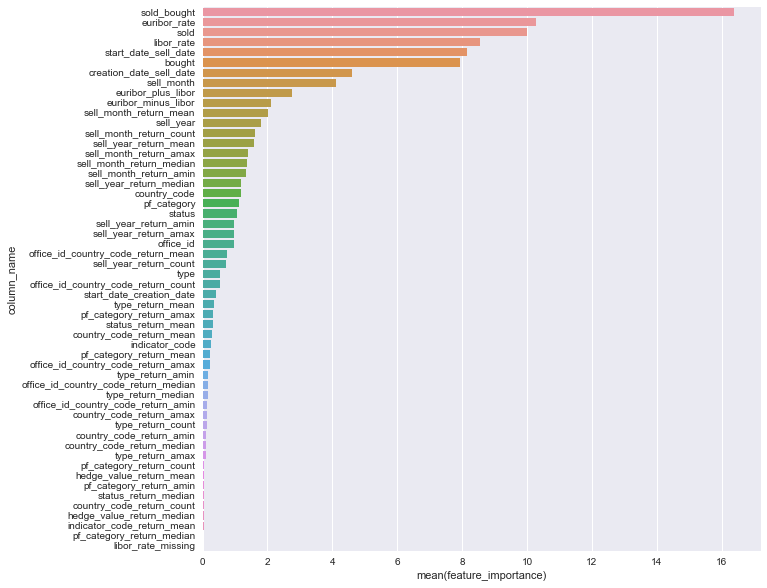

In [26]:
# plot the feature importances
df_feature_importance = pd.DataFrame(list(zip((input_cols_xgb_encode + input_cols_xgb_numeric), \
                                              xgb_reg.feature_importances_)),\
                                     columns = ['column_name', 'feature_importance'])
df_feature_importance = df_feature_importance.sort_values(by = 'feature_importance', ascending = False).reset_index()
df_feature_importance['feature_importance'] *= 100
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10 , 10))
sns.barplot(x = 'feature_importance', y = 'column_name', data = df_feature_importance)

In [152]:
df_feature_importance

,index,column_name,feature_importance
0,5,euribor_rate,15.406749
1,6,libor_rate,12.703811
2,4,sold,10.890226
3,7,bought,8.666841
4,13,start_date_sell_date,8.039062
5,14,creation_date_sell_date,6.591682
6,11,sell_month,5.309966
7,10,sell_year,3.252245
8,35,sell_year_return_mean,2.214666
9,2,country_code,2.205946


In [27]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

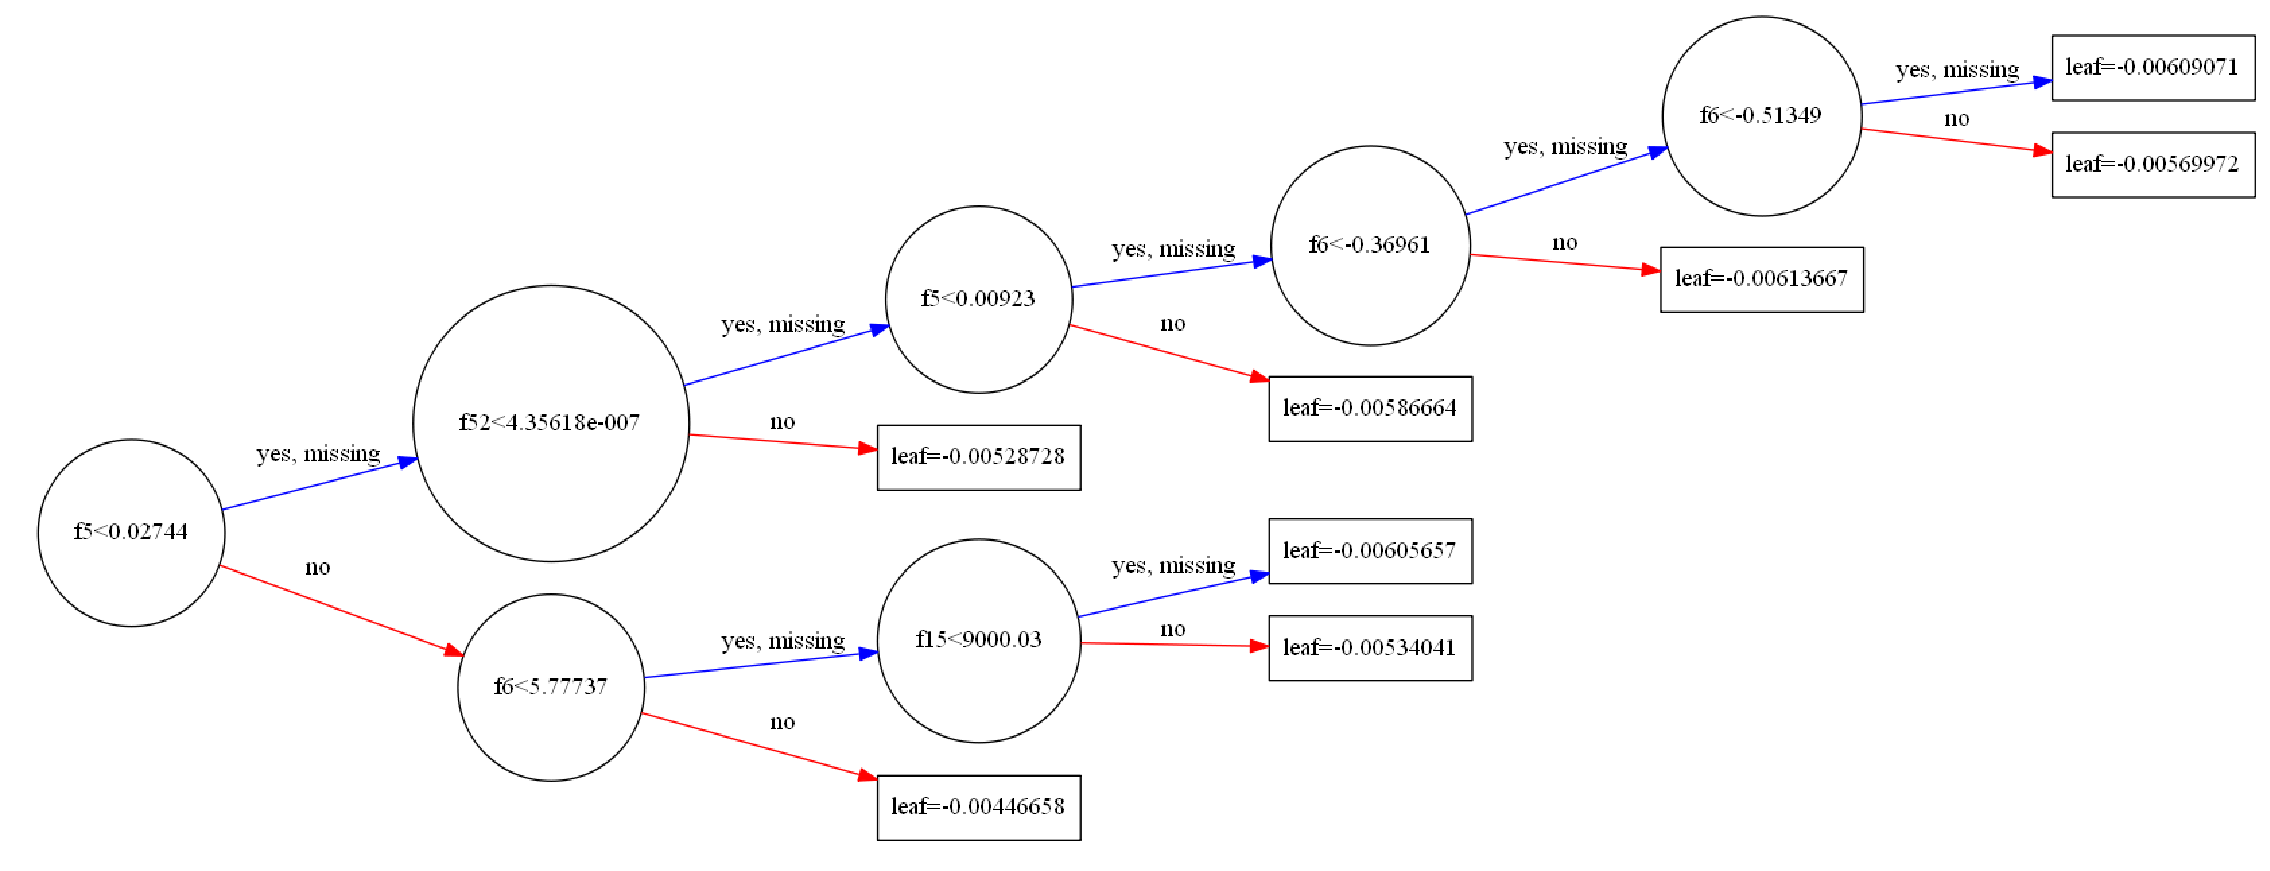

In [28]:
# plot the tree
fig, axs = plt.subplots(nrows = 1, figsize = (40, 20))
plot_tree(xgb_reg, num_trees = 20, rankdir = 'LR', ax = axs)

In [29]:
# make predictions on the test set
df_test = pd.read_csv('../inputs/test.csv')

In [30]:
df_test = etl_pipeline(df_test, is_train=False, create_interactions=True, fillna_dict=fillna_dict,\
                      df_grouping_train=df_grouping_train)

In [31]:
print (df_test.columns)

Index(['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date',
       'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate',
       'bought', 'creation_date', 'indicator_code', 'sell_date', 'type',
       'hedge_value', 'status', 'has_desk_id', 'has_hedge_value', 'sell_year',
       'sell_month', 'start_date_creation_date', 'start_date_sell_date',
       'creation_date_sell_date', 'sold_bought', 'libor_rate_missing',
       'euribor_plus_libor', 'euribor_minus_libor', 'pf_category_return_mean',
       'pf_category_return_median', 'pf_category_return_amax',
       'pf_category_return_amin', 'pf_category_return_count',
       'country_code_return_mean', 'country_code_return_median',
       'country_code_return_amax', 'country_code_return_amin',
       'country_code_return_count', 'type_return_mean', 'type_return_median',
       'type_return_amax', 'type_return_amin', 'type_return_count',
       'indicator_code_return_mean', 'indicator_code_return_median',
       '

In [32]:
# make predictions on the test set with the optimum parameters
X_xgb_test = df_test[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()

for i in range(len(label_enc)):
    X_xgb_test[:, i] = label_enc[i].transform(X_xgb_test[:, i])

df_submit = pd.DataFrame(df_test['portfolio_id'])
df_submit['return'] = xgb_reg.predict(X_xgb_test)

df_submit.to_csv('../submissions/submit_20171218_0027_xgb.csv', index=False)


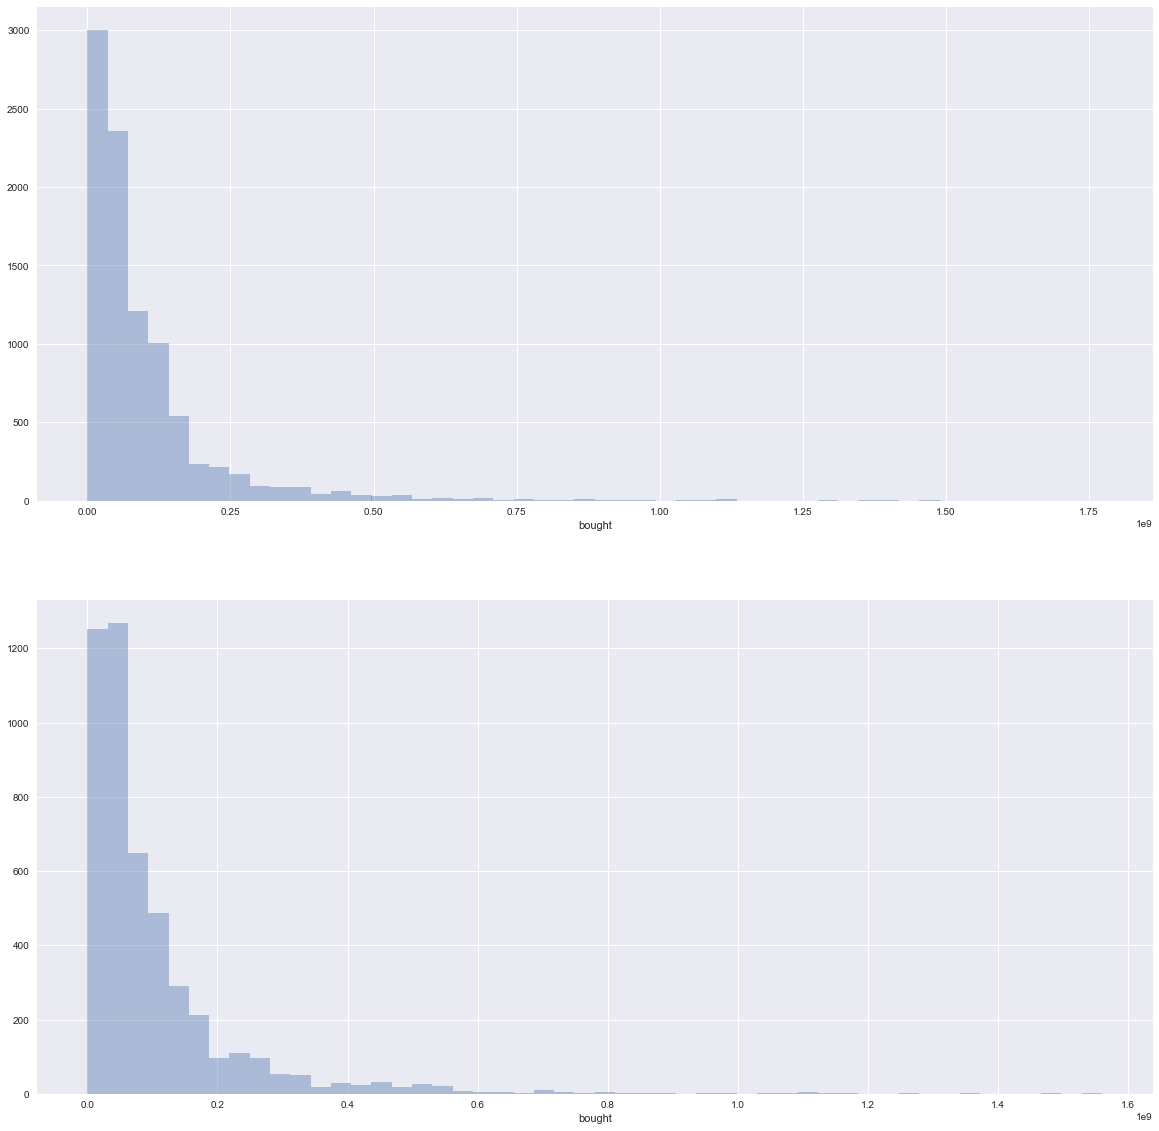

In [41]:
var = 'bought'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20 , 20))
sns.distplot(df.loc[df['sold_bought'] > -2.5e+5, var], ax = axs[0], kde=False)
sns.distplot(df_test[var], ax = axs[1], kde=False)

In [37]:
print (df['sold_bought'].sort_values().head(10))
print ((df['sold_bought']).describe())
print (df_test['sold_bought'].describe())

7466   -2.602705e+06
8034   -2.180339e+05
7464   -2.093125e+05
8647   -1.351810e+05
9103   -1.307788e+05
8872   -1.265971e+05
8085   -1.004125e+05
7689   -9.842410e+04
7648   -9.178789e+04
7779   -9.061993e+04
Name: sold_bought, dtype: float64
count    9.356000e+03
mean     8.227913e+04
std      2.576593e+05
min     -2.602705e+06
25%      1.805671e+03
50%      8.422815e+03
75%      3.915617e+04
max      3.229342e+06
Name: sold_bought, dtype: float64
count    4.801000e+03
mean     7.775883e+04
std      2.406707e+05
min     -1.952065e+05
25%      1.761696e+03
50%      7.333628e+03
75%      3.652275e+04
max      3.495974e+06
Name: sold_bought, dtype: float64


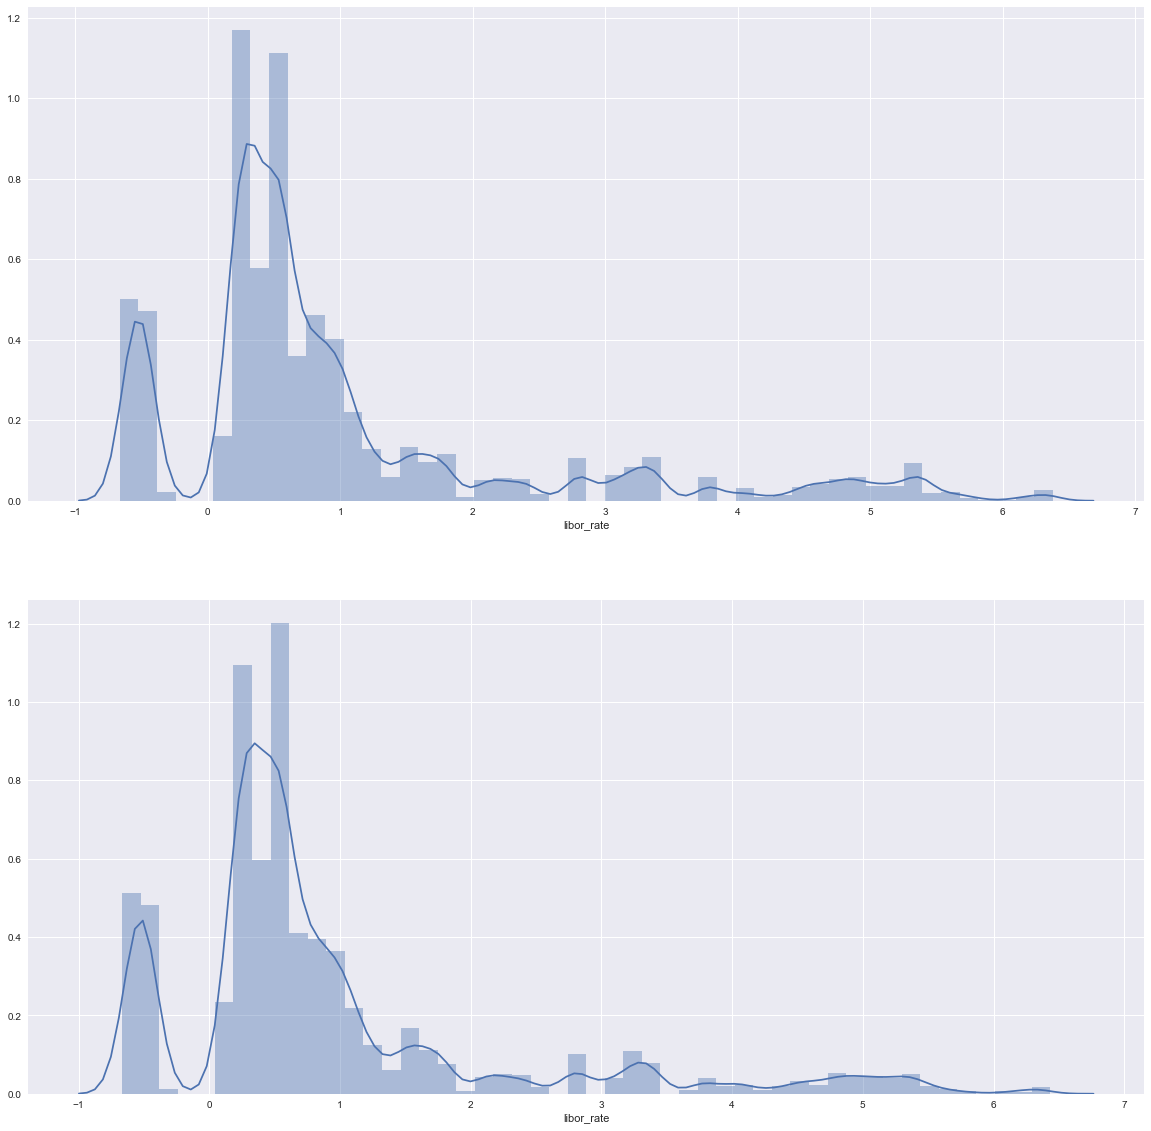

In [151]:
var = 'libor_rate'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20 , 20))
sns.distplot(df[var], ax = axs[0])
sns.distplot(df_test[var], ax = axs[1])